In [25]:
import re
import networkx as nx
import random
import numpy as np
import pdb
import datetime

In [26]:
p = re.compile("\d+\d+") # Regex expression to parse an edge
def stringParser(a):
  return [int(s) for s in a.split() if s.isdigit()]

In [27]:
# Function to sample wedges from edge_reservoir
# We set k = 10^3
def getWedges():
  k = 10**3 # Wedge sampling param (see paper)
  wedges=list() # List that will be returned
  r1 = list(G) # Get all nodes as list
  #pdb.set_trace()
  sampling = random.sample(r1, len(r1)) if len(r1)<k else random.sample(r1,k) # Randomise all nodes (see paper)
  for node in sampling:
    if len(list(G[node]))>=2: # If a node has 2 or more edges
      neighbors = random.sample(list(G[node]), 2) # Get neighbors
      wedge = Wedge(node, neighbors[0], neighbors[1]) # create a wedge
      wedges.append(wedge) # Add that node to wedges array, aka tot_wedges
  return wedges


In [28]:
# Class to define an edge of three nodes and check if it is closed

class Wedge():
  def __init__(self, node1, node2, node3):
    self.node1 = node1
    self.node2 = node2
    self.node3 = node3
  
  # Function to know if current wedge is closed or not
  def isClosed(self):
    if (self.node3 in list(G[self.node1]) and self.node2 in list(G[self.node1]) and self.node3 in list(G[self.node2])):
      return True
    else:
      return False
  
  # Function to get nodes as a list
  def getNodes(self):
    return [self.node1, self.node2, self.node3]


In [62]:
# Main computation from the algorithm.
def update(parsed):
  #pdb.set_trace()
  new_wedges = 0
  Nt = [] # Array with new wedges from the current edge (parsed)
  ind = False # This variable will indecate if there were any updates of edge_reservoir
  ind2 = True # This indicates if we have to delete the edge from the nx graph
  for i in range(0, wedge_size):
    #pdb.set_trace()
    if wedge_reservoir[i] != 0: # This is to avoid run errors with empty arrays
      if wedge_reservoir[i].isClosed(): # Check if wedge is closed
        isClosed[i] = True
  for i in range(0, edge_size): # Reservoir sampling over edge_reservoir
    x = random.random()
    if x <= 1/t:
      edge_reservoir[i] = parsed
      ind = True # We have modified the edge_reservoir
      ind2 = False # This keeps the edge in the graph
  if ind == True: # We added a new edge!
    wedges = getWedges() # Get a sample of wedges from the graph
    tot_wedges = len(wedges) # Number of wedges
    if tot_wedges != 0: # This happens if there were new wedges
      #pdb.set_trace()
      for wedge in wedges:
        # If the new wedges are linked with the edge attribute (et), append to Nt
        if parsed[0] in wedge.getNodes() or parsed[1] in wedge.getNodes(): 
          Nt.append(wedge)
          new_wedges = len(Nt)
      for i in range(0, wedge_size): # Reservoir sampling over wedge_reservoir
        x = random.random()
        #pdb.set_trace()
        if x <= new_wedges/tot_wedges:
          #print("Tot_wedges is {}".format(tot_wedges))
          #pdb.set_trace()
          w = random.choice(Nt)
          wedge_reservoir[i] = w
          isClosed[i] = False
  if ind2==True: # We didn't modify edge_reservoir, so delete edge
    #pdb.set_trace()
    G.remove_edges_from([tuple(parsed)]) # Remove that edge from graph
    tot_wedges = 0 # We know this hasn't changed
  return tot_wedges

In [72]:
# Initialization
global tot_wedges
iterations = []
minutes = 5
endTime = datetime.datetime.now() + datetime.timedelta(minutes=minutes) # Set a time algorithm can be running
edge_size = 100
edge_reservoir = list(np.zeros(edge_size))
wedge_size = 100
wedge_reservoir = list(np.zeros(wedge_size))
#pdb.set_trace()
isClosed = list(np.zeros(wedge_size))
G = nx.Graph() # Create graph. It will have the same edges as edge_reservoir
fileName = "/content/drive/MyDrive/Colab Notebooks/lab3_dm/web-BerkStan.txt" # large data
#fileName = "/content/drive/MyDrive/Colab Notebooks/lab3_dm/graph_short.txt" # short data
t = 1 # Number of lines read (index of et)
triangle_count = [] # Number of triangles
transitivity = [] # Transitivity values
with open(fileName, 'r+') as f:
    # Beginning of algorithm
    for edge in f: # For each new edge from the graph:
      tot_wedges = 0 # Initialize total_wedges to 0
      parsed = stringParser(edge) # Parse the edge to ints
      G.add_edges_from([tuple(parsed)]) # Add that edge to main graph. We need it for isClosed to work!
      #pdb.set_trace()
      try:
        tot_wedges = update(tuple(parsed))
      except:
        #pdb.set_trace()
        print("Unexpected error, printing variables:")
        print("Triangle avg: {}".format(sum(triangle_count) / len(triangle_count)))
        print("Transitivity avg: {}".format(sum(transitivity)/len(transitivity)))
        print("Iterations t :{}".format(t))
        raise
      ro = sum(isClosed) # Parameter for computing triangles
      kt = 3*ro # Transitivity
      #if kt != 0:
        #pdb.set_trace()
      Tt= ((ro*t**2)/(edge_size*(edge_size-1)))*tot_wedges # Triangle count
      t = t+1 # Update edge count
      iterations.append(t)
      triangle_count.append(Tt) # Add to list
      transitivity.append(kt) # Add to list
      if datetime.datetime.now() >= endTime:
        break
      
      #print("Kt is {} and Tt is {}".format(kt, Tt))
      #print("Number of line is {}".format(t))

<Figure size 432x288 with 0 Axes>

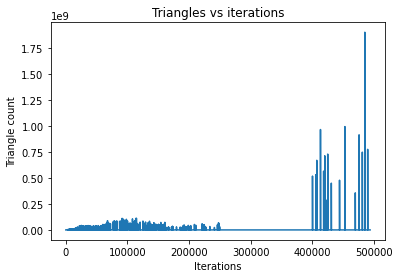

<Figure size 432x288 with 0 Axes>

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(iterations, triangle_count)
plt.title("Triangles vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Triangle count")
plt.figure()

<Figure size 432x288 with 0 Axes>

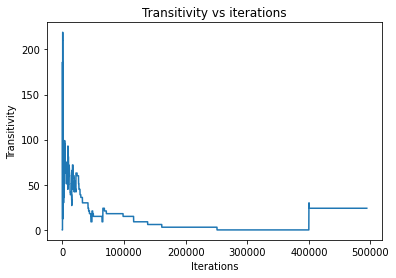

<Figure size 432x288 with 0 Axes>

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(iterations, transitivity)
plt.title("Transitivity vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Transitivity")
plt.figure()